# Mean Reversion investing trading strategy


The Mean Reversion strategy assumes that a stock's price will ultimately return to its long-term average level. Stretching too far out, like a rubber band, will cause it to snap back.

In [1]:
!pip install mpl_finance
!pip install yfinance
!pip install --upgrade pandas
!pip install --upgrade pandas-datareader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np, pandas as pd
# dataloader
import pandas_datareader.data as web
from pandas_datareader import data as pdr
import yfinance as yf
yf.pdr_override()
# date
import datetime as dt
import matplotlib.dates as mdates
# stats
from scipy import stats
from scipy.stats import norm, skew
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy import signal
# visualization
from mpl_finance import candlestick_ohlc
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pandas.plotting import autocorrelation_plot
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

import warnings

warnings.filterwarnings("ignore")
matplotlib.rc('figure', figsize=(16, 6))

In [3]:
def clear(df):
    print(f"Length of data before: {len(df)}")
    df.dropna(inplace=True)
    print(f"Length of data after: {len(df)}")

In [4]:
# VanEck Egypt Index ETF 
ticker = 'EGPT'
start = dt.datetime(2018, 1, 1)
end = dt.datetime.today()

df = pdr.get_data_yahoo(ticker, start, end)
df.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2023-02-28,18.100000,18.480000,18.040001,18.280001,18.280001,9000
2023-03-01,18.330000,18.379999,18.100000,18.299999,18.299999,10500
2023-03-02,18.200001,18.309999,18.100000,18.150000,18.150000,12400
2023-03-03,18.139999,18.450001,18.139999,18.379999,18.379999,600
2023-03-06,18.480000,18.480000,18.100000,18.190001,18.190001,4784


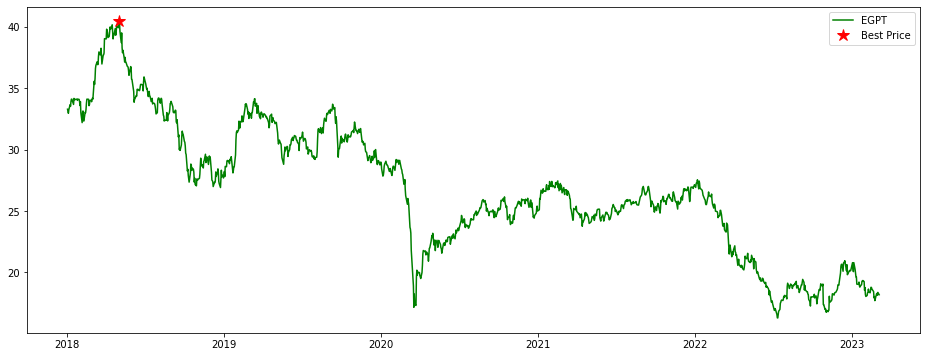

In [5]:
plt.plot(df['Close'], color = 'g', label = ticker)
plt.plot(df.loc[df.Close == max(df['Close'])].index, max(df['Close']), '*', color = 'r', markersize = 12, label='Best Price')
plt.legend()

## Moving Averages (21 days)

In [6]:
period = 21
df['21-day'] = df['Close'].rolling(period).mean()
df['std'] = df['Close'].rolling(period).std()

# calculate bollinger bands using std dev
df['upper_bollinger'] = df['21-day'] + (2 * df['std'])
df['lower_bollinger'] = df['21-day'] - (2 * df['std'])

clear(df)

Length of data before: 1302
Length of data after: 1282


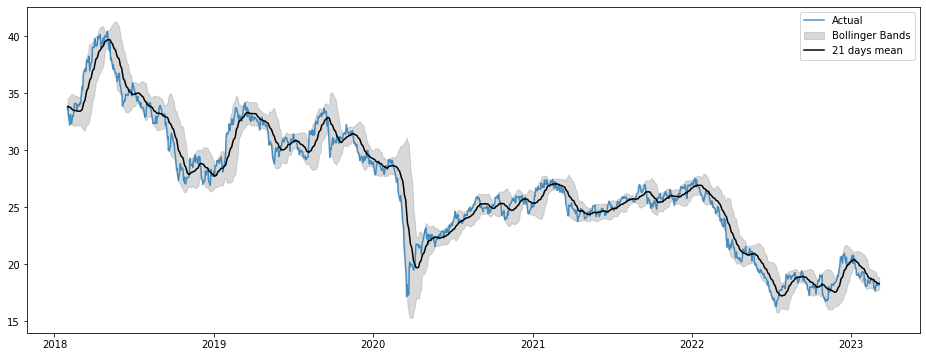

In [7]:
plt.plot(df['Close'], label='Actual', alpha=0.8)
plt.fill_between(df.index,df['lower_bollinger'], df['upper_bollinger'], color='gray', alpha=0.3, label = 'Bollinger Bands')
plt.plot(df['21-day'], color='black', label='21 days mean')
plt.legend();

## Ratio

    Close / 21-days avg

In [8]:
df['ratio'] = df['Close'] / df['21-day']

display( df['ratio'].describe() )

count    1282.000000
mean        0.995588
std         0.040383
min         0.697522
25%         0.973566
50%         0.998163
75%         1.019725
max         1.113406
Name: ratio, dtype: float64

In [9]:
percentiles = np.percentile(df['ratio'], [5, 50, 95])

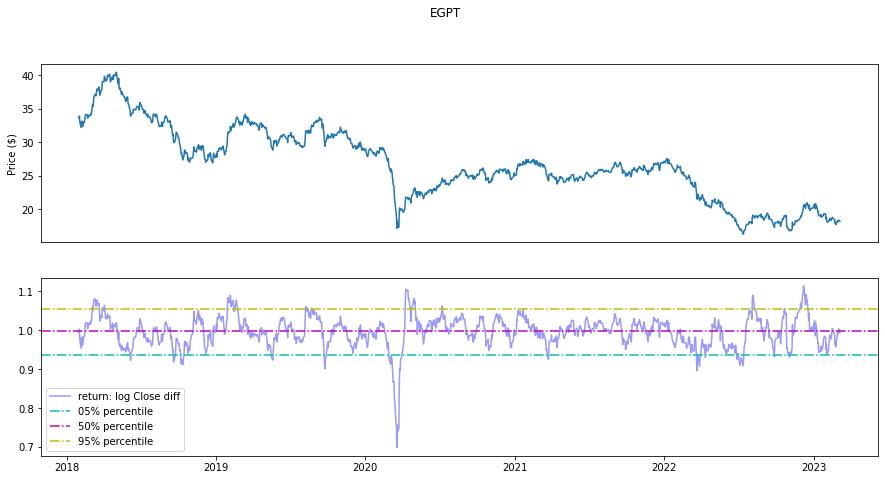

In [10]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))
ax1.get_xaxis().set_visible(False)
fig.suptitle(ticker)

df['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')

ax2.plot(df['ratio'], color='b', label='return: log Close diff', alpha=0.4);
ax2.axhline(percentiles[0], c = 'c', ls='-.', label=f'05% percentile')
ax2.axhline(percentiles[1], c = 'm', ls='-.', label=f'50% percentile')
ax2.axhline(percentiles[2], c = 'y', ls='-.', label=f'95% percentile')
#ax2.set_ylim(0, 100)
ax2.legend();

## position

    short: if ratio > 95% percentile -> position = -1
    long: if ratio < 5% percentile -> position = 1

In [11]:
df['position'] = np.where(df.ratio > percentiles[2], -1, np.nan)        # short
df['position'] = np.where(df.ratio < percentiles[0], 1, df['position']) # long
df['position'] = df['position'].ffill().fillna(0)

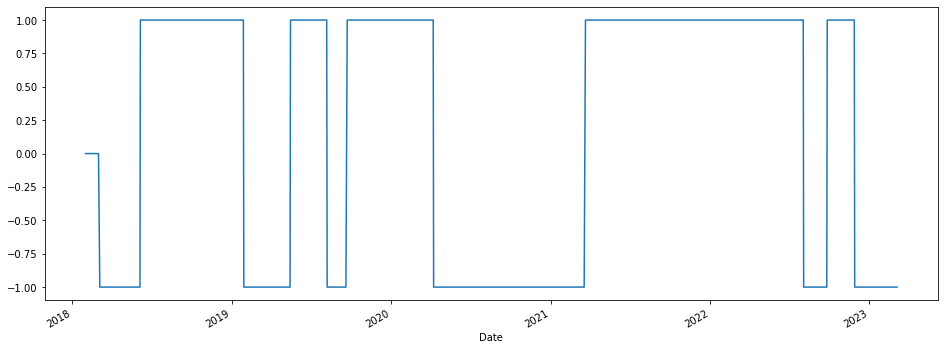

In [12]:
df.position.plot();

## Relative Strength Index (RSI)

RSI measures the speed and magnitude of a security's recent price changes to evaluate overvalued or undervalued conditions in the price of that security.




In [13]:
def RSI(df):
    deltas = df['Close'].diff(1).dropna()
    up = deltas.clip(lower=0)
    down = deltas.clip(upper=0)
    df.fillna('0', inplace=True)
    
    avg_gain = up.rolling(window=period).mean()
    #avg_gain = up.ewm(period).mean()
    avg_loss = abs(down.rolling(window=period).mean())
    #avg_loss = up.down(period).mean()

    relation_strength = avg_gain / avg_loss
    return 100. - (100. / (1. + relation_strength))

df['RSI'] = RSI(df)

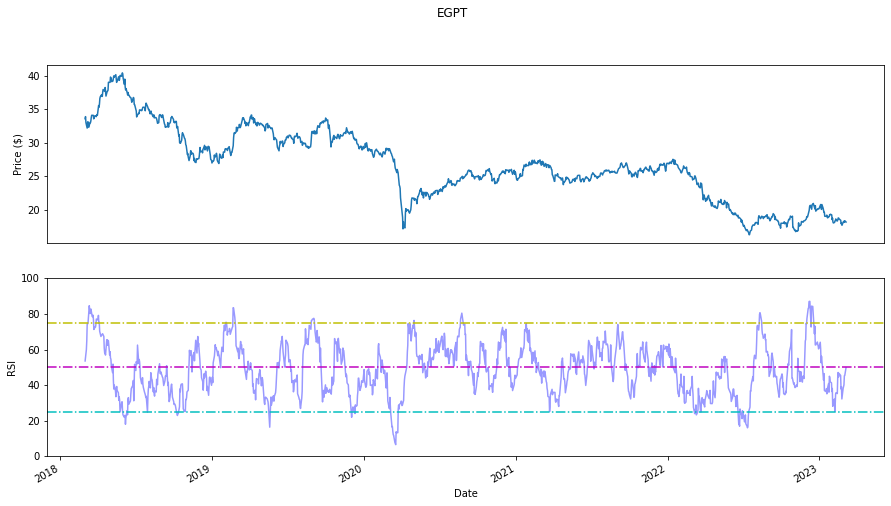

In [14]:
fig, (ax1, ax2) = plt.subplots(2, figsize=(15, 8))
ax1.get_xaxis().set_visible(False)
fig.suptitle(ticker)

df['Close'].plot(ax=ax1)
ax1.set_ylabel('Price ($)')

df['RSI'].plot(color='b', label='RSI', alpha=0.4, ax=ax2)
ax2.set_ylim(0, 100)
ax2.axhline(25, color='c', linestyle='-.')
ax2.axhline(50, color='m', linestyle='-.')
ax2.axhline(75, color='y', linestyle='-.')
ax2.set_ylabel('RSI');

## Implementing buy/sell
Rules:
1. Buy when 10-period RSI below 30 (buy next day) & Price below lower bollinger band
2. Sell when 10-period RSI above 70 (sell next day) & Price above upper bollinger band

In [15]:
# long signal
df['signal'] = np.where( (df['RSI'] < 30) & (df['Close'] < df['lower_bollinger']), 1, np.nan)
# short signal
df['signal'] = np.where( (df['RSI'] > 70) & (df['Close'] > df['upper_bollinger']), -1, df['signal'])

#buy/sell next trading day
df['signal'] = df['signal'].shift().fillna(0)

In [16]:
# Look through last year data
start_date = dt.datetime.now() - dt.timedelta(days=1*365)
#mask = (df.index > start_date) & (df.index <= end_date)
mask = (df.index > start_date)
df_2022 = df.loc[mask]
df_2022.head()

,Open,High,Low,Close,Adj Close,Volume,21-day,std,upper_bollinger,lower_bollinger,ratio,position,RSI,signal
Date,,,,,,,,,,,,,,
2022-03-07,24.200001,24.600000,23.559999,23.780001,23.477079,75200,25.241428,0.675443,26.592314,23.890543,0.942102,1.0,24.050631,0.0
2022-03-08,23.850000,24.400000,23.379999,23.920000,23.615295,25500,25.130952,0.693440,26.517832,23.744072,0.951814,1.0,26.229498,1.0
2022-03-09,24.360001,24.360001,23.440001,23.780001,23.477079,17900,25.017143,0.710304,26.437750,23.596536,0.950548,1.0,25.858577,0.0
2022-03-10,23.600000,24.570000,23.600000,23.990000,23.684402,16500,24.913809,0.693372,26.300553,23.527066,0.962920,1.0,28.932021,0.0
2022-03-11,23.900000,23.900000,23.430000,23.480000,23.180899,8300,24.775714,0.675312,26.126337,23.425091,0.947702,1.0,23.345576,0.0


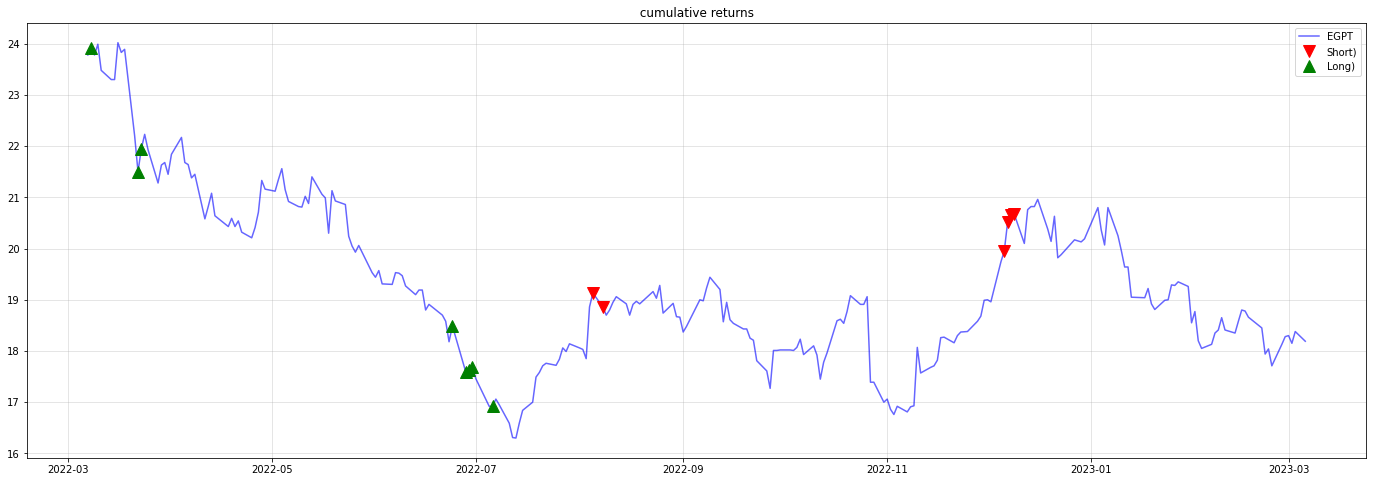

In [17]:
plt.figure(figsize=(24, 8))
plt.grid(True, alpha = .4)

plt.plot(df_2022['Close'], color='b', label = ticker, alpha=0.6)

plt.plot(df_2022.loc[df.signal == -1].index, df_2022['Close'][df_2022.signal == -1], 'v', color = 'r', markersize = 12, label = 'Short)')
plt.plot(df_2022.loc[df.signal == 1].index, df_2022['Close'][df_2022.signal == 1], '^', color = 'g', markersize = 12, label = 'Long)')
plt.title(" cumulative returns ")
plt.legend(loc='upper right');

## system Performance

In [18]:
df['return'] = np.log(df["Close"]).diff()
df['system_return'] = df['return'] * df['position'].shift()

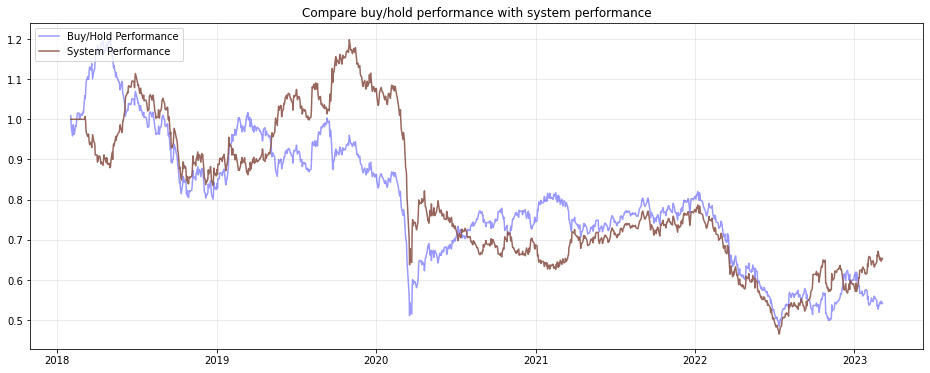

In [19]:
plt.grid(True, alpha=.3)
plt.plot(np.exp(df['return']).cumprod(), color='b', alpha=0.4, label='Buy/Hold Performance')
plt.plot(np.exp(df['system_return']).cumprod(), color='tab:brown', alpha=0.9, label='System Performance')
plt.title('Compare buy/hold performance with system performance')
plt.legend(loc='upper left');

## Check Last day performance

In [20]:
print(f"Last day actual performance: {np.exp(df['return']).cumprod()[-1] -1}")
print(f"Last day system performance: {np.exp(df['system_return']).cumprod()[-1] - 1}")

Last day actual performance: -0.45830853060777343
Last day system performance: -0.3462506692090689
